In [1]:

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from xgboost import plot_importance, plot_tree
import pandas as pd
import numpy as np
import xgboost

## Daten einlesen

In [ ]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

In [17]:


# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'CompetitionOpen', 'Promo2Open', 'CompetitionDistance', 'fourier_sin_365', 'fourier_cos_365' ]

#'lag_1', 'lag_7','fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday' , 'rolling_mean_7', 'rolling_std_7' 
# Bereits encodierte Features
already_encoded_features = ['Promo', 'Promo2', 'SchoolHoliday','IsPromo2Month' ]

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday' ] # 'Store' entfernt


## Visualisierung

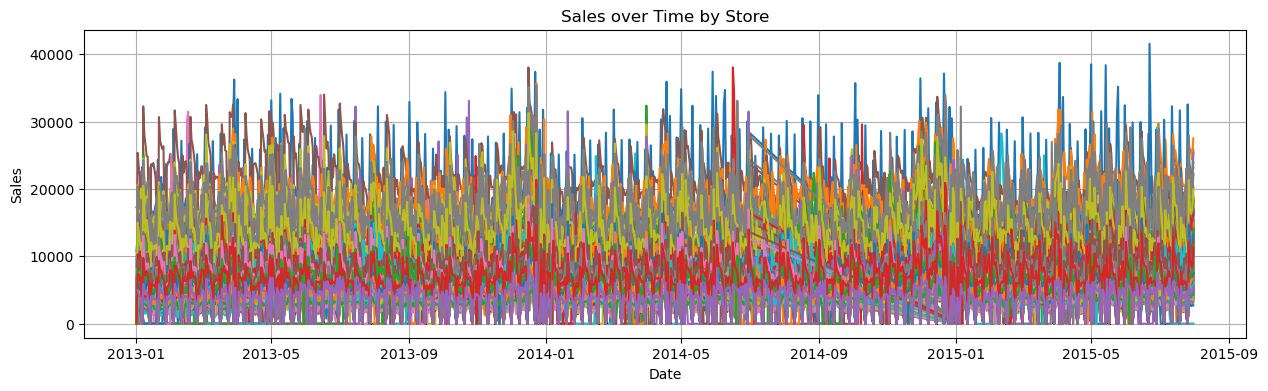

In [218]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming data_cleaned is your DataFrame
# Ensure that data_cleaned is a DataFrame, not a string or another type
if isinstance(data, pd.DataFrame):
    # Convert 'Date' to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Plot Sales over time, grouping by Store
    plt.figure(figsize=(15,4))
    for store in data['Store'].unique():
        store_data = data[data['Store'] == store]
        plt.plot(store_data['Date'], store_data['Sales'], label=f'Store {store}')

    plt.title('Sales over Time by Store')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(True)
    plt.show()
else:
    print("Error: data_cleaned is not a DataFrame.")

## Split

In [18]:
# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')

data = data[data ['Open']!=0]
data = data[data ['Sales']>0]
#data = data[data ['StateHoliday']!=1]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']


# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

In [149]:
X_train

,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,year,month,day,quarter,...,PromoInterval,promo2,CompetitionOpen,Promo2Open,IsPromo2Month,lag_1,lag_7,rolling_mean_7,rolling_std_7,is_closed_next_day
511718,562,2,2013-01-01,0,a,1,2013,1,1,1,...,NaN,0,0.0,0.000000,0,20212.0,18462.0,NaN,NaN,0
699720,769,2,2013-01-01,0,a,1,2013,1,1,1,...,"Jan,Apr,Jul,Oct",1,0.0,1.213115,0,11188.0,10125.5,NaN,NaN,0
237398,262,2,2013-01-01,0,a,1,2013,1,1,1,...,NaN,0,0.0,0.000000,0,20224.5,18799.5,NaN,NaN,0
466458,512,2,2013-01-01,0,a,1,2013,1,1,1,...,"Mar,Jun,Sept,Dec",0,0.0,0.000000,0,5420.0,5160.0,NaN,NaN,0
863186,948,2,2013-01-01,0,a,1,2013,1,1,1,...,NaN,0,0.0,0.000000,0,6790.0,6496.5,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603181,662,5,2015-01-30,1,0,0,2015,1,30,1,...,NaN,0,0.0,0.000000,0,9445.0,6110.0,7755.571429,4137.418231,0
966872,1060,5,2015-01-30,1,0,0,2015,1,30,1,...,"Feb,May,Aug,Nov",0,0.0,18.032787,0,8564.0,6570.0,6242.000000,3269.136022,0
858293,942,5,2015-01-30,1,0,0,2015,1,30,1,...,"Jan,Apr,Jul,Oct",1,0.0,45.016393,0,5614.0,4952.0,5112.142857,2432.029155,0
925586,1015,5,2015-01-30,1,0,0,2015,1,30,1,...,"Mar,Jun,Sept,Dec",0,49.0,47.081967,0,6596.0,5432.0,4899.285714,2349.354998,0


In [148]:
X_test

,Store,DayOfWeek,Date,Promo,StateHoliday,SchoolHoliday,year,month,day,quarter,...,PromoInterval,promo2,CompetitionOpen,Promo2Open,IsPromo2Month,lag_1,lag_7,rolling_mean_7,rolling_std_7,is_closed_next_day
215917,238,5,2015-01-30,1,0,0,2015,1,30,1,...,"Feb,May,Aug,Nov",0,0.0,62.819672,0,9035.0,5291.0,6390.428571,3428.558291,0
503241,552,5,2015-01-30,1,0,0,2015,1,30,1,...,"Jan,Apr,Jul,Oct",1,78.0,64.655738,0,8060.0,5663.0,6847.714286,3904.044301,0
843589,926,5,2015-01-30,1,0,0,2015,1,30,1,...,"Jan,Apr,Jul,Oct",1,46.0,58.163934,0,7863.0,6533.0,6422.142857,3196.560935,0
1004574,1101,5,2015-01-30,1,0,0,2015,1,30,1,...,NaN,0,28.0,0.000000,0,10809.0,8427.0,8891.571429,4436.252430,0
512477,562,5,2015-01-30,1,0,0,2015,1,30,1,...,NaN,0,0.0,0.000000,0,19776.0,18149.0,18420.571429,2564.953662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315075,346,5,2015-07-31,1,0,1,2015,7,31,3,...,NaN,0,0.0,0.000000,0,7781.0,7235.0,6496.857143,3123.615503,1
314133,345,5,2015-07-31,1,0,0,2015,7,31,3,...,"Jan,Apr,Jul,Oct",1,0.0,38.065574,0,5459.0,4052.0,4655.571429,2456.669348,1
313375,344,5,2015-07-31,1,0,1,2015,7,31,3,...,"Jan,Apr,Jul,Oct",1,51.0,51.901639,0,10488.0,7536.0,8370.714286,4148.792343,1
879015,964,5,2015-07-31,1,0,1,2015,7,31,3,...,"Feb,May,Aug,Nov",0,0.0,29.967213,0,12407.0,7351.0,9040.428571,4395.727807,1


## Metrik

In [4]:

# Angepasste RMSPE-Funktion, die Tage mit 0 Sales ignoriert
def rmspe(y_true, y_pred):
    # Nur Fälle berücksichtigen, bei denen y_true nicht 0 ist
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

In [5]:
# RMSPE als Scorer definieren
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

## Kreuzvalidierung (TimeSeries)

In [20]:
from sklearn.model_selection import TimeSeriesSplit
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

## Pre-processing

In [6]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

## Lineare Regression (Base Model)

In [150]:
# Erstelle die Pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['month', 'day',
                                                   'week_of_year', 'Promo2Open',
                                                   'CompetitionDistance']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'SchoolHoliday',
                                                   'promo2', 'Promo2',
                                                   'is_weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'Assortment', 'StateHoliday',
                                                   'quarter'])])),
                ('model', LinearRegression())])

In [151]:
# Cross-Validation durchführen
cv_scores = cross_val_score(pipeline_lr, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [152]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-4583286403.414057

## XGBoost

In [537]:
import xgboost

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgboost.XGBRegressor())
])

NameError: name 'cross_val_score' is not defined

In [538]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'CompetitionOpen',
                                                   'Promo2Open',
                                                   'CompetitionDistance',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'Promo2',
                                                   'SchoolHoliday',
                                                   'IsPromo2Month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'S...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [539]:
cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [540]:
cv_scores

array([-0.38646328, -0.31272996, -0.32933889, -0.38062445, -0.43866843])

In [541]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-0.369565000493027

In [542]:
y_pred = pipeline_xgb.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.29508210686536074

In [138]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)

In [139]:
# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)
# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')
data = data[data ['Open']!=0]
data = data[data ['Sales']>0]
#data = data[data ['StateHoliday']!=1]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']


# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

In [140]:

from sklearn.model_selection import TimeSeriesSplit
# Zeitreihen-Kreuzvalidierung einrichten
tscv = TimeSeriesSplit(n_splits=5)

In [146]:

# Definiere die numerischen und kategorischen Features
numerical_features = [ 'month', 'day', 'week_of_year', 'Promo2Open', 'CompetitionDistance']

#'lag_1', 'lag_7','fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday' , 'rolling_mean_7', 'rolling_std_7' 
# Bereits encodierte Features
already_encoded_features = ['Promo', 'SchoolHoliday','promo2', 'Promo2', 'is_weekend']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday', 'quarter' ] # 'Store' entfernt

# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

import xgboost

# Pipeline für die Modellierung
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
   # ('feature_selection', SelectFromModel(estimator=xgboost.XGBRegressor(), threshold=0.000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
    ('model', xgboost.XGBRegressor())  # Schritt 3: Modellierung
])

pipeline_xgb.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline_xgb, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

mean_rmspe = np.mean(cv_scores)


y_pred = pipeline_xgb.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)

print(mean_rmspe)
print(test_rmspe)

-0.3364188849229886
0.29434758604784933


In [ ]:
-0.3494912979958401
0.28949810659378694

In [ ]:
numerical_features = [ 'month', 'day', 'week_of_year', 'CompetitionOpen', 'Promo2Open', 'CompetitionDistance']
already_encoded_features = ['Promo', 'SchoolHoliday','IsPromo2Month', 'promo2', 'Promo2']
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday' ]
-0.34126111152819505
0.2905700345403563


numerical_features = ['year', 'month', 'day', 'week_of_year', 'CompetitionOpen', 'Promo2Open', 'CompetitionDistance', 'fourier_sin_365', 'fourier_cos_365' ]
already_encoded_features = ['Promo', 'Promo2', 'SchoolHoliday','IsPromo2Month' ]
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday' ] # 'Store' entfernt
RMSPE = 0.369565000493027, 0.29508210686536074

In [ ]:

numerical_features = ['year', 'month', 'day', 'week_of_year', 'CompetitionOpen', 'Promo2Open', 'CompetitionDistance']
already_encoded_features = ['Promo', 'Promo2', 'SchoolHoliday','IsPromo2Month' ]
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday' ] # 'Store' entfernt
-0.3692824677223995
0.2852478567521077

In [549]:
numerical_features = ['year', 'month', 'day', 'week_of_year', 'CompetitionOpen', 'Promo2Open', 'CompetitionDistance']
already_encoded_features = ['Promo', 'Promo2', 'SchoolHoliday','IsPromo2Month' ]
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment' ] # 'Store' entfernt
-0.36280088472167693
0.3081158741417678

0.3081158741417678

In [ ]:
numerical_features = ['year', 'month', 'day', 'week_of_year', 'CompetitionOpen', 'Promo2Open', 'CompetitionDistance']
already_encoded_features = ['Promo', 'Promo2','IsPromo2Month' ]
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday' ] # 'Store' entfernt
-0.36003181275226226
0.29337483804078585

In [558]:
numerical_features = ['year', 'month', 'day', 'week_of_year', 'Promo2Open', 'CompetitionDistance']
already_encoded_features = ['Promo', 'Promo2','IsPromo2Month' ]
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday' ] # 'Store' entfernt
-0.36130615041609265
0.2832629187091402

0.2832629187091402

In [ ]:
numerical_features = ['month', 'day', 'week_of_year', 'CompetitionOpen', 'Promo2Open', 'CompetitionDistance']
already_encoded_features = ['Promo', 'Promo2','IsPromo2Month' ]
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday' ] # 'Store' entfernt
-0.35169496522280896
0.2924827062697009

In [115]:
# Erstelle die Pipeline
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['month', 'day',
                                                   'week_of_year',
                                                   'CompetitionOpen',
                                                   'Promo2Open',
                                                   'CompetitionDistance']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'SchoolHoliday',
                                                   'promo2', 'Promo2']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'StoreType',
                                                   'Assortment',
                                                   'StateHoliday'])])),
                ('model', LinearRegression())])

In [118]:
cv_scores = cross_val_score(pipeline_lr, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [119]:
mean_rmspe = np.mean(cv_scores)
mean_rmspe

-5333408149.916968

## Feature Selection XGBoost

In [103]:
# Angenommen, dein 'preprocessor' ist ein ColumnTransformer
preprocessor = pipeline_xgb.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor.fit_transform(X_train)

# Falls die Anzahl der Features gleich bleibt:
feature_names = X_train.columns

# Falls die Anzahl der Features verändert wurde, musst du die neuen Feature-Namen entsprechend abrufen:
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline_xgb.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

,Feature,Importance
6,enc__Promo,0.146700
18,cat__StoreType_b,0.137272
10,cat__DayOfWeek_1,0.094926
9,enc__Promo2,0.071268
20,cat__StoreType_d,0.056064
21,cat__Assortment_a,0.051694
5,num__CompetitionDistance,0.048016
17,cat__StoreType_a,0.043125
19,cat__StoreType_c,0.041376
23,cat__Assortment_c,0.036831


In [104]:
feature_importance_df[feature_importance_df['Importance'] > 0.0000]

,Feature,Importance
6,enc__Promo,0.146700
18,cat__StoreType_b,0.137272
10,cat__DayOfWeek_1,0.094926
9,enc__Promo2,0.071268
20,cat__StoreType_d,0.056064
21,cat__Assortment_a,0.051694
5,num__CompetitionDistance,0.048016
17,cat__StoreType_a,0.043125
19,cat__StoreType_c,0.041376
23,cat__Assortment_c,0.036831


In [105]:
feature_importance_df[feature_importance_df['Importance'] == 0]

,Feature,Importance
27,cat__StateHoliday_c,0.0


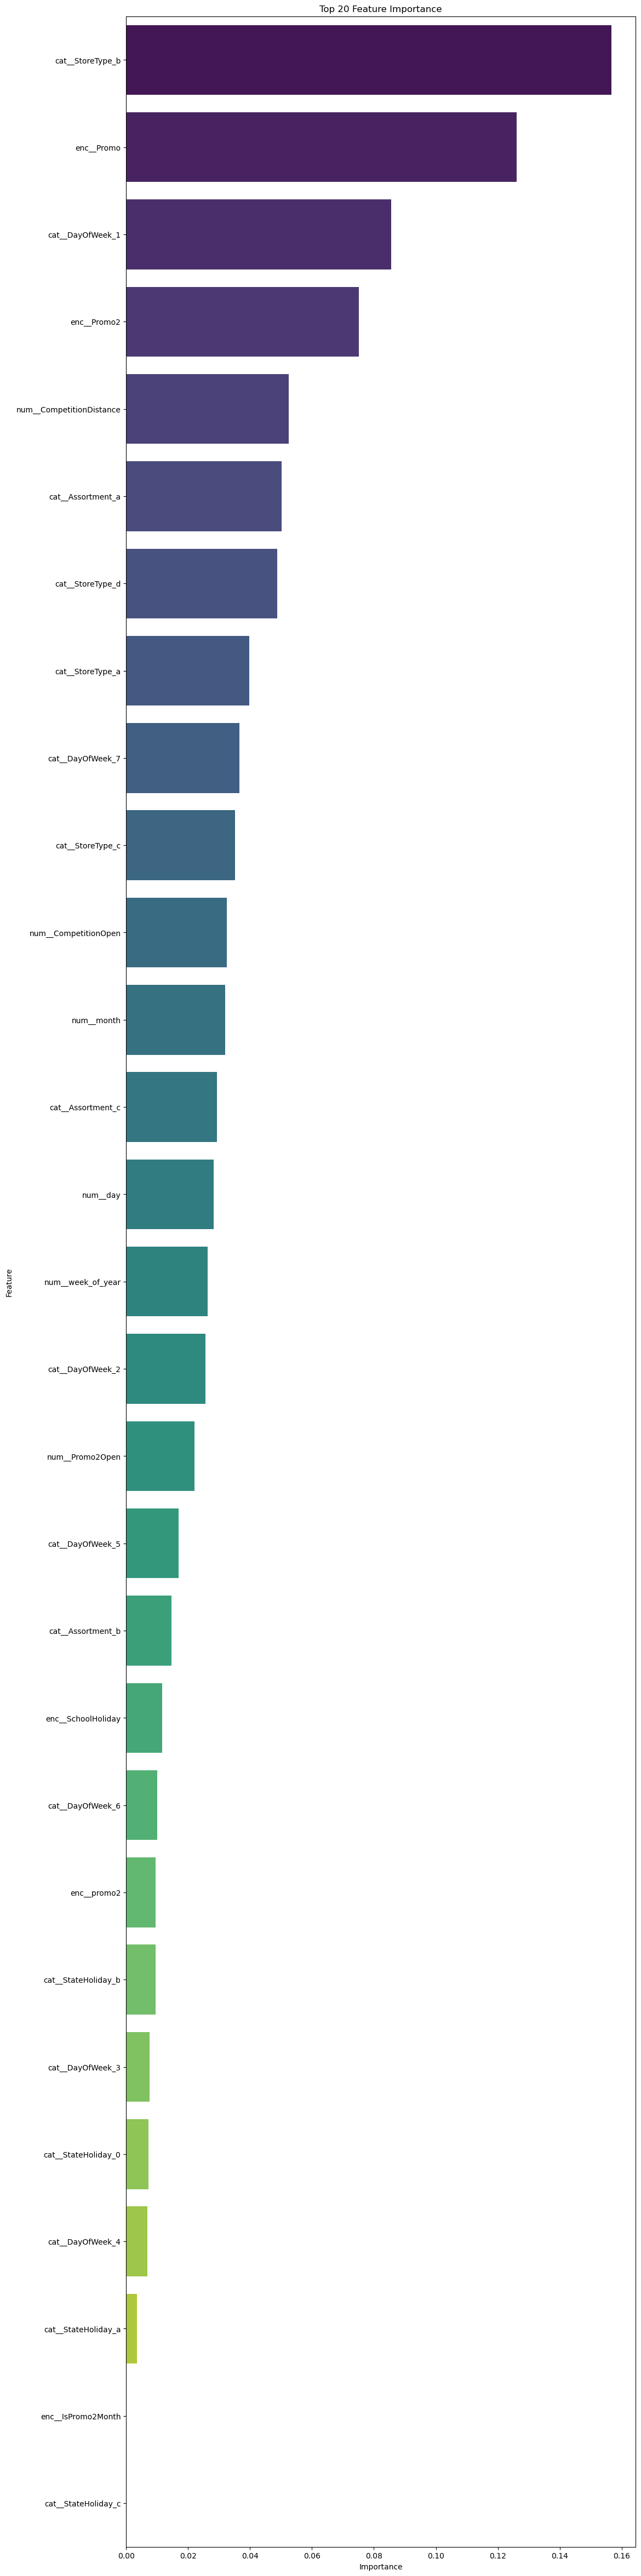

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anzahl der anzuzeigenden Top-Features
top_n = 30

# Sortiere die DataFrame nach 'Importance' und zeige nur die Top-n Features
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:357]

# Setze die Größe der Abbildung
plt.figure(figsize=(12,60))

# Erstelle das Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Füge Titel und Beschriftungen hinzu
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen, falls nötig
plt.yticks(rotation=0)

# Zeige das Diagramm an
plt.show()

## Feature Selection

In [210]:
# Angenommen, dein 'preprocessor' ist ein ColumnTransformer
preprocessor = pipeline_gb.named_steps['preprocessor']

# Transformiere die Trainingsdaten, um die Feature-Namen nach der Transformation zu erhalten
X_train_transformed = preprocessor.fit_transform(X_train)

# Falls die Anzahl der Features gleich bleibt:
feature_names = X_train.columns

# Falls die Anzahl der Features verändert wurde, musst du die neuen Feature-Namen entsprechend abrufen:
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()

# Feature Importances abrufen
importances = pipeline_gb.named_steps['model'].feature_importances_

# Features und ihre Wichtigkeit zusammenstellen
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sortieren nach Wichtigkeit
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Ausgabe der Feature Importance
feature_importance_df

NameError: name 'pipeline_gb' is not defined

In [ ]:
feature_importance_df[feature_importance_df['Importance'] > 0.0000]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Anzahl der anzuzeigenden Top-Features
top_n = 30

# Sortiere die DataFrame nach 'Importance' und zeige nur die Top-n Features
feature_importance_df_2 = feature_importance_df.sort_values(by='Importance', ascending=False)[:30]

# Setze die Größe der Abbildung
plt.figure(figsize=(12, 8))

# Erstelle das Balkendiagramm
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_2, palette='viridis')

# Füge Titel und Beschriftungen hinzu
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Rotieren der y-Achsenbeschriftungen, falls nötig
plt.yticks(rotation=0)

# Zeige das Diagramm an
plt.show()

In [ ]:
unwichtige_features = feature_importance_df[feature_importance_df["Importance"] == 0].Feature.tolist()
unwichtige_features

In [ ]:
len(unwichtige_features)

#### Unwichtige Features aussortieren (feature importance = 0)

In [293]:
# Apply the preprocessing pipeline to your data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [ ]:
# Fit a model to determine feature importances
initial_model = GradientBoostingRegressor()
initial_model.fit(X_train_preprocessed, y_train)

In [ ]:
# Select important features
selector = SelectFromModel(estimator=initial_model, threshold= 0.000001, prefit=True)
X_train_selected = selector.transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

#### Liste der relevanten Features anzeigen

In [215]:
# Step 3: Get the feature names after preprocessing
# For numerical features
numerical_feature_names = numerical_features

# For already encoded features (they remain the same)
already_encoded_feature_names = already_encoded_features

# For categorical features (get the feature names after one-hot encoding)
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features_to_encode)

# Combine all feature names
all_feature_names = list(numerical_feature_names) + list(already_encoded_feature_names) + list(categorical_feature_names)

In [193]:
# Step 6: Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Step 7: Map the selected features to their names
selected_feature_names = [all_feature_names[i] for i in selected_feature_indices]

# Step 8: Create a DataFrame with feature names and their data types
selected_features_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Data Type': [X_train_preprocessed.dtype] * len(selected_feature_names)
})

# Display the DataFrame
print(selected_features_df)

           Feature Data Type
0             year   float64
1            month   float64
2              day   float64
3     week_of_year   float64
4            lag_1   float64
5            lag_7   float64
6             Open   float64
7            Promo   float64
8           promo2   float64
9      DayOfWeek_1   float64
10     DayOfWeek_2   float64
11     DayOfWeek_3   float64
12     DayOfWeek_5   float64
13     DayOfWeek_6   float64
14     DayOfWeek_7   float64
15     StoreType_a   float64
16     StoreType_b   float64
17     StoreType_d   float64
18  StateHoliday_0   float64
19  StateHoliday_c   float64
20    Assortment_a   float64
21    Assortment_b   float64
22       Store_251   float64
23       Store_262   float64
24       Store_733   float64
25       Store_756   float64
26       Store_788   float64
27       Store_817   float64
28       Store_842   float64
29      Store_1114   float64


## Pipeline mit FeatureSelection

In [526]:
# Pipeline für die Modellierung
pipeline_gb_fs = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('feature_selection', SelectFromModel(estimator=xgboost.XGBRegressor(), threshold=0.000000000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
    ('model', xgboost.XGBRegressor())  # Schritt 3: Modellierung
])

In [527]:
# Anpassung und Vorhersage
pipeline_gb_fs.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month', 'day',
                                                   'week_of_year',
                                                   'CompetitionOpen',
                                                   'Promo2Open',
                                                   'CompetitionDistance',
                                                   'fourier_sin_365',
                                                   'fourier_cos_365']),
                                                 ('enc', 'passthrough',
                                                  ['Promo', 'Promo2',
                                                   'SchoolHoliday',
                                                   'IsPromo2Month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['DayOfWeek', 'S...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [528]:
cv_scores_fs = cross_val_score(pipeline_gb_fs, X_train, y_train, cv=tscv, scoring=rmspe_scorer, verbose=True)

In [529]:
mean_rmspe_fs = np.mean(cv_scores_fs)
mean_rmspe_fs

-0.3729192639880414

In [530]:
y_pred = pipeline_gb_fs.predict(X_test)
test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.32453870084555614

## Test ChatGPT Lag

In [184]:
# Verbesserte iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-7:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-30 ist 30 Tage zurück
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Durchführung der Kreuzvalidierung auf den Trainingsdaten
rmspe_scores = []  # Liste zur Speicherung der RMSPE-Scores

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1
RMSPE for Fold 1: 0.7059624450713108
Fold 2


KeyboardInterrupt: 

In [ ]:
# Verbesserte iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-7:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Durchführung der Kreuzvalidierung auf den Trainingsdaten
rmspe_scores = []  # Liste zur Speicherung der RMSPE-Scores

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

In [298]:
# Verbesserte iterative Vorhersagefunktion (mit Berücksichtigung von Lag-, Rolling- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-7:])  # Letzte 7 Tage tatsächlicher Sales-Daten
    
    # Berechnung des anfänglichen rolling_mean_7 und rolling_std_7
    initial_rolling_mean_7 = np.mean(last_known_sales)
    initial_rolling_std_7 = np.std(last_known_sales)
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück

            # Rolling-Features berechnen
            row["rolling_mean_7"] = np.mean(last_known_sales[-7:]) if len(last_known_sales) >= 7 else initial_rolling_mean_7
            row["rolling_std_7"] = np.std(last_known_sales[-7:]) if len(last_known_sales) >= 7 else initial_rolling_std_7
        
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
            row["rolling_mean_7"] = np.nan
            row["rolling_std_7"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

block_split_cv = BlockedTimeSeriesSplitByBlock(n_splits=5, train_size=0.99, test_size=0.01)
# Iteriere über die Folds der Block-Kreuzvalidierung
for fold, (train_index, test_index) in enumerate(block_split_cv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1
RMSPE for Fold 1: 0.6181894101674195
Fold 2
RMSPE for Fold 2: 0.5351163402022362
Fold 3
RMSPE for Fold 3: 0.4105807088985242
Fold 4
RMSPE for Fold 4: 0.5314432723570736
Fold 5
RMSPE for Fold 5: 1.757272792264378
Durchschnittliche RMSPE über alle Folds: 0.7705205047779262


In [252]:
# Verbesserte iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-7:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück
            #row["lag_30"] = last_known_sales[-30] if len(last_known_sales) >= 30 else np.nan  # Lag-30 ist 30 Tage zurück
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
            #row["lag_30"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Durchführung der Kreuzvalidierung auf den Trainingsdaten
rmspe_scores = []  # Liste zur Speicherung der RMSPE-Scores

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1
RMSPE for Fold 1: 1.6097376951359197
Fold 2
RMSPE for Fold 2: 2.0545905143653433
Fold 3


KeyboardInterrupt: 

In [279]:
# Verbesserte iterative Vorhersagefunktion (mit Berücksichtigung von Lag-, Rolling- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-7:])  # Letzte 7 Tage tatsächlicher Sales-Daten
    
    # Berechnung des anfänglichen rolling_mean_7 und rolling_std_7
    initial_rolling_mean_7 = np.mean(last_known_sales)
    initial_rolling_std_7 = np.std(last_known_sales)
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück

            # Rolling-Features berechnen
            row["rolling_mean_7"] = np.mean(last_known_sales[-7:]) if len(last_known_sales) >= 7 else initial_rolling_mean_7
            row["rolling_std_7"] = np.std(last_known_sales[-7:]) if len(last_known_sales) >= 7 else initial_rolling_std_7
        
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
            row["rolling_mean_7"] = np.nan
            row["rolling_std_7"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Durchführung der Kreuzvalidierung auf den Trainingsdaten
rmspe_scores = []  # Liste zur Speicherung der RMSPE-Scores

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1


KeyboardInterrupt: 

In [179]:
# Verbesserte iterative Vorhersagefunktion (mit Berücksichtigung von Lag- und zusätzlichen Features)
def iterative_forecast(pipeline, X_fold_train, y_fold_train, X_fold_val):
    # Trainiere das Modell mit allen Features
    pipeline.named_steps['model'].fit(X_fold_train, y_fold_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_fold_train[-7:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    # Iteriere über die Zeilen von X_fold_val
    for index, row in X_fold_val.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück
            #row["lag_30"] = last_known_sales[-30] if len(last_known_sales) >= 30 else np.nan  # Lag-30 ist 30 Tage zurück
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
            #row["lag_30"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Durchführung der Kreuzvalidierung auf den Trainingsdaten
rmspe_scores = []  # Liste zur Speicherung der RMSPE-Scores

for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    
    # Train- und Testdaten für diesen Fold
    X_fold_train = X_train.iloc[train_index]
    X_fold_test = X_train.iloc[test_index]
    y_fold_train = y_train.iloc[train_index]
    y_fold_test = y_train.iloc[test_index]
    
    # Preprocessing auf die Train- und Testdaten anwenden
    X_fold_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_fold_train)
    X_fold_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_fold_test)
    
    # Iterative Vorhersage über die Testperiode
    y_pred = iterative_forecast(pipeline_gb_fs, X_fold_train_preprocessed, y_fold_train, X_fold_test)
    
    # RMSPE berechnen und speichern
    rmspe_score = rmspe(y_fold_test, y_pred)
    rmspe_scores.append(rmspe_score)
    
    print(f"RMSPE for Fold {fold + 1}: {rmspe_score}")

# Gesamtergebnisse
print(f"Durchschnittliche RMSPE über alle Folds: {np.mean(rmspe_scores)}")

Fold 1
RMSPE for Fold 1: 1.8269958334300087
Fold 2


KeyboardInterrupt: 

## Test

In [232]:
# Funktion zur iterativen Vorhersage auf den Testdaten
def iterative_test_forecast(pipeline, X_train, y_train, X_test):
    # Trainiere das Modell mit allen Features der Trainingsdaten
    pipeline.named_steps['model'].fit(X_train, y_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_train[-30:])  # Letzte 30 Tage tatsächlicher Sales-Daten aus dem Trainingsdatensatz
    
    # Iteriere über die Zeilen von X_test
    for index, row in X_test.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück
            row["lag_30"] = last_known_sales[-30] if len(last_known_sales) >= 30 else np.nan  # Lag-30 ist 30 Tage zurück
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
            row["lag_30"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Preprocessing auf den gesamten Trainings- und Testdatensatz anwenden
X_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_train)
X_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_test)

# Iterative Vorhersage auf den Testdaten
y_test_pred = iterative_test_forecast(pipeline_gb_fs, X_train_preprocessed, y_train, X_test)

# Berechne den RMSPE für die Testdaten
rmspe_test = rmspe(y_test, y_test_pred)
print(f"RMSPE for Test Data: {rmspe_test}")

RMSPE for Test Data: 1.5939681323934796


In [149]:
# Funktion zur iterativen Vorhersage auf den Testdaten
def iterative_test_forecast(pipeline, X_train, y_train, X_test):
    # Trainiere das Modell mit allen Features der Trainingsdaten
    pipeline.named_steps['model'].fit(X_train, y_train)
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_train[-30:])  # Letzte 30 Tage tatsächlicher Sales-Daten aus dem Trainingsdatensatz
    
    # Iteriere über die Zeilen von X_test
    for index, row in X_test.iterrows():
        try:
            # Lag-Features für den nächsten Tag berechnen
            row["lag_1"] = last_known_sales[-1]  # Lag-1 ist der zuletzt vorhergesagte Wert
            row["lag_7"] = last_known_sales[-7] if len(last_known_sales) >= 7 else np.nan  # Lag-7 ist 7 Tage zurück
            row["lag_30"] = last_known_sales[-30] if len(last_known_sales) >= 30 else np.nan  # Lag-30 ist 30 Tage zurück
        except IndexError as e:
            print(f"Error in creating lag features for row {index}: {e}")
            row["lag_1"] = np.nan
            row["lag_7"] = np.nan
            row["lag_30"] = np.nan
        
        # Wandeln der Zeile in einen DataFrame, um den Preprocessing-Schritt durchzuführen
        row = row.to_frame().T
        
        # Wende das Preprocessing an
        row_preprocessed = pipeline.named_steps['preprocessor'].transform(row)
        
        # Vorhersage für den nächsten Tag
        pred = pipeline.named_steps['model'].predict(row_preprocessed)
        predictions.append(pred[0])  # pred ist ein Array, daher pred[0]
        
        # Update der letzten bekannten Sales-Daten
        last_known_sales.append(pred[0])
    
    return predictions

# Preprocessing auf den gesamten Trainings- und Testdatensatz anwenden
X_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_train)
X_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_test)

# Iterative Vorhersage auf den Testdaten
y_test_pred = iterative_test_forecast(pipeline_gb_fs, X_train_preprocessed, y_train, X_test)

# Berechne den RMSPE für die Testdaten
rmspe_test = rmspe(y_test, y_test_pred)
print(f"RMSPE for Test Data: {rmspe_test}")

RMSPE for Test Data: 0.335548384722048


In [97]:
rmspe_scores

[0.22462106290226325,
 0.17938804343249987,
 0.20868198787032732,
 0.17054493156616898,
 0.3560938126230344]

In [98]:
# Durchschnittliche MSE über alle Folds
average_rmspe = np.mean(rmspe_scores)
print(f"\nAverage RMSPE over all folds (Training): {average_rmspe}")


Average RMSPE over all folds (Training): 0.2278659676788588


In [106]:
# Iterative Vorhersagefunktion für den Testdatensatz (ohne manuelle Hinzufügung von Lag-Features)
def iterative_forecast_test(model, X_train, y_train, X_test_preprocessed):
    # Trainiere das Modell mit den Trainingsdaten
    model.fit(X_train, y_train)
    
    # Anzahl der Testtage
    forecast_days = X_test_preprocessed.shape[0]  # Anzahl der Testtage anhand der Zeilenanzahl
    
    # Vorhersagen auf Basis der Testdaten
    predictions = []
    last_known_sales = list(y_train[-30:])  # Letzte 30 Tage tatsächlicher Sales-Daten
    
    for i in range(forecast_days):
        # Hole die transformierten Features für den nächsten Testtag
        additional_features = X_test_preprocessed[i].reshape(1, -1)  # Transformierte Features in 2D
        
        # Keine manuelle Hinzufügung von Lag-Features - Verwende nur die transformierten Features
        input_data = additional_features  # Nur die transformierten Features verwenden
        
        # Vorhersage für den nächsten Tag
        next_pred = model.predict(input_data)[0]
        predictions.append(next_pred)
        
        # Update der letzten bekannten Sales-Daten mit der Vorhersage (dynamische Lag-Feature-Berechnung)
        last_known_sales.append(next_pred)
    
    return predictions

# Preprocessing auf die Trainingsdaten anwenden
X_train_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].fit_transform(X_train)

# Transformiere die Testdaten und wandle das spärliche Array in eine dichte Matrix um
X_test_preprocessed = pipeline_gb_fs.named_steps['preprocessor'].transform(X_test).toarray()

# Iterative Vorhersage für den Testdatensatz (ohne manuelle Hinzufügung von Lag-Features)
y_test_pred = iterative_forecast_test(pipeline_gb_fs.named_steps['model'], X_train_preprocessed, y_train, X_test_preprocessed)

# Berechnung des RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)
print(f"\nRMSPE on test data: {test_rmspe}")


RMSPE on test data: 3.876259807793845


## Hyperparameter Optimierung

### Optuna

In [31]:
import optuna
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
import xgboost as xgb

In [467]:
# Optuna-Objective-Funktion
def objective(trial):
    # Hyperparameter-Vorschläge durch Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10)
    }
    
    # XGBoost-Modell mit den vorgeschlagenen Parametern
    model = xgb.XGBRegressor(**params)
    
    # Erstelle die Pipeline mit dem Preprocessing und dem Modell
    pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
            ('feature_selection', SelectFromModel(estimator=xgboost.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
            ('model', model)   
    ])
    
    # Cross-Validation Score berechnen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    
    # Rückgabe des negativen Durchschnitts, da Optuna standardmäßig minimiert
    return -np.mean(cv_scores)

# Optuna-Studie erstellen und Optimierung starten
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Beste Hyperparameter nach der Optimierung
best_params = study.best_params
print("Beste Hyperparameter: ", best_params)

[I 2024-09-05 14:22:39,503] A new study created in memory with name: no-name-9544f020-55fb-4cdd-bd5c-bfcebda699f0


[I 2024-09-05 14:22:55,175] Trial 0 finished with value: 0.2654673943405536 and parameters: {'n_estimators': 169, 'max_depth': 6, 'learning_rate': 0.06377926187129744, 'subsample': 0.9237093792000572, 'colsample_bytree': 0.608826436732448, 'gamma': 1.0566879148625452}. Best is trial 0 with value: 0.2654673943405536.
[I 2024-09-05 14:23:10,238] Trial 1 finished with value: 0.2709215224123923 and parameters: {'n_estimators': 177, 'max_depth': 5, 'learning_rate': 0.05831281082852016, 'subsample': 0.9788827276536332, 'colsample_bytree': 0.7274715269415326, 'gamma': 6.033864214142774}. Best is trial 0 with value: 0.2654673943405536.
[I 2024-09-05 14:23:32,607] Trial 2 finished with value: 0.2925112637333495 and parameters: {'n_estimators': 275, 'max_depth': 8, 'learning_rate': 0.44586876894152566, 'subsample': 0.5957439973951844, 'colsample_bytree': 0.5752888513990005, 'gamma': 9.13961158562744}. Best is trial 0 with value: 0.2654673943405536.
[I 2024-09-05 14:24:03,784] Trial 3 finished wi

Beste Hyperparameter:  {'n_estimators': 272, 'max_depth': 7, 'learning_rate': 0.08272492672161898, 'subsample': 0.8812401504258377, 'colsample_bytree': 0.5027019175949335, 'gamma': 5.759774067169282}


In [32]:
# Optuna-Objective-Funktion
def objective(trial):
    # Hyperparameter-Vorschläge durch Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10)
    }
    
    # XGBoost-Modell mit den vorgeschlagenen Parametern
    model = xgb.XGBRegressor(**params)
    
    # Erstelle die Pipeline mit dem Preprocessing und dem Modell
    pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
            ('feature_selection', SelectFromModel(estimator=xgboost.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
            ('model', model)   
    ])
    
    # Cross-Validation Score berechnen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=blocked_cv_by_block, scoring=rmspe_scorer)
    
    # Rückgabe des negativen Durchschnitts, da Optuna standardmäßig minimiert
    return -np.mean(cv_scores)

# Optuna-Studie erstellen und Optimierung starten
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Beste Hyperparameter nach der Optimierung
best_params = study.best_params
print("Beste Hyperparameter: ", best_params)

[I 2024-09-09 23:33:35,356] A new study created in memory with name: no-name-9a8fedd5-04d7-402b-9828-b428b6f3c8d1
[I 2024-09-09 23:33:40,783] Trial 0 finished with value: 0.2299760680867709 and parameters: {'n_estimators': 67, 'max_depth': 8, 'learning_rate': 0.025315268467040096, 'subsample': 0.6262941330531727, 'colsample_bytree': 0.9860691329424169, 'gamma': 2.40604431503865}. Best is trial 0 with value: 0.2299760680867709.
[I 2024-09-09 23:33:48,163] Trial 1 finished with value: 0.40207986399026235 and parameters: {'n_estimators': 240, 'max_depth': 5, 'learning_rate': 0.0017518036294037374, 'subsample': 0.8869159578174814, 'colsample_bytree': 0.5606347486414663, 'gamma': 4.356516609633616}. Best is trial 0 with value: 0.2299760680867709.
[I 2024-09-09 23:33:52,710] Trial 2 finished with value: 0.2562247708673496 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.6717848668768764, 'subsample': 0.6523147170554089, 'colsample_bytree': 0.693091641230775, 'gamma': 8

Beste Hyperparameter:  {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.07270894723811805, 'subsample': 0.7353410114740687, 'colsample_bytree': 0.6324177089861035, 'gamma': 4.433296674087877}


#### RandomizesGridSearch

In [539]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import numpy as np

# Definiere die Hyperparameter-Verteilungen, die getestet werden sollen
param_distributions = {
    'model__n_estimators': [50, 100, 150, 200, 250, 300],
    'model__max_depth': [3, 4, 5, 6, 7, 8],
    'model__learning_rate': np.logspace(-3, 0, num=100),  # Logarithmische Verteilung für den Lernrate
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 1, 2, 3, 4, 5, 10]
}

# XGBoost-Modell initialisieren
model = xgb.XGBRegressor()

# Erstelle die Pipeline mit dem Preprocessing und dem Modell
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('feature_selection', SelectFromModel(estimator=xgb.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
    ('model', model)   # Schritt 3: Modell
])

# Definiere die RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,  # Die gesamte Pipeline als Schätzer
    param_distributions=param_distributions,  # Hyperparameter-Verteilungen
    n_iter=50,  # Anzahl der Iterationen (wie viele zufällige Kombinationen getestet werden)
    cv=tscv,  # TimeSeriesSplit für zeitabhängige Daten
    scoring=rmspe_scorer,  # Der benutzerdefinierte Scorer
    n_jobs=-1,  # Parallele Jobs (so viele wie möglich)
    verbose=2,  # Ausgabe von Zwischenergebnissen
    random_state=42  # Setze einen festen Seed für Reproduzierbarkeit
)

# Starte die RandomizedSearch-Optimierung
random_search.fit(X_train, y_train)

# Beste Hyperparameter nach der Optimierung
best_params = random_search.best_params_
print("Beste Hyperparameter: ", best_params)

# Ergebnis des besten Modells
best_score = random_search.best_score_
print("Bester Score: ", best_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__colsample_bytree=0.9, model__gamma=3, model__learning_rate=0.0016297508346206436, model__max_depth=4, model__n_estimators=100, model__subsample=0.6; total time=   6.8s
[CV] END model__colsample_bytree=0.9, model__gamma=3, model__learning_rate=0.0016297508346206436, model__max_depth=4, model__n_estimators=100, model__subsample=0.6; total time=   9.8s
[CV] END model__colsample_bytree=0.5, model__gamma=5, model__learning_rate=0.08697490026177834, model__max_depth=6, model__n_estimators=250, model__subsample=0.7; total time=  10.6s
[CV] END model__colsample_bytree=0.9, model__gamma=3, model__learning_rate=0.0016297508346206436, model__max_depth=4, model__n_estimators=100, model__subsample=0.6; total time=  15.8s
[CV] END model__colsample_bytree=0.5, model__gamma=5, model__learning_rate=0.08697490026177834, model__max_depth=6, model__n_estimators=250, model__subsample=0.7; total time=  18.2s
[CV] END model__colsam

### Optuna 2

In [224]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = GradientBoostingRegressor(n_iter_no_change=5, **params)
    cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring=rmspe_scorer)
    return -np.mean(cv_scores)

study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, n_trials=50)
best_params = study2.best_params

[I 2024-08-30 23:42:13,069] A new study created in memory with name: no-name-c76b5a9c-5cbf-4403-a923-ed319070bb84
[I 2024-08-31 00:01:08,925] Trial 0 finished with value: 0.21275163750250298 and parameters: {'n_estimators': 107, 'max_depth': 7, 'learning_rate': 0.44300679502587403, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.21275163750250298.
[I 2024-08-31 00:19:42,129] Trial 1 finished with value: 0.3432867450899385 and parameters: {'n_estimators': 163, 'max_depth': 5, 'learning_rate': 0.007669382805689857, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.21275163750250298.
[I 2024-08-31 00:42:12,425] Trial 2 finished with value: 0.26731454564087925 and parameters: {'n_estimators': 154, 'max_depth': 6, 'learning_rate': 0.018388625486154716, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.21275163750250298.
[I 2024-08-31 00:54:58,735] Trial 3 finished with value: 0.24186243511078778 and parame

Bestes Ergebnis: GradientBoostingRegressor ( n_estimators= 237, max_depth = 8, learning_rate = 0.22484530035059536, min_samples_split = 5, min_samples_leaf = 7)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import numpy as np

# Definiere die Hyperparameter-Raster, die getestet werden sollen
param_grid = {
    'model__n_estimators': [50, 150, 300],  # Weniger Werte für die Anzahl der Bäume
    'model__max_depth': [3, 5, 7],  # Reduzierte Tiefe
    'model__learning_rate': [0.01, 0.1, 0.3],  # Wichtige Zwischenwerte
    'model__subsample': [0.6, 0.8, 1.0],  # Repräsentative Auswahl
    'model__colsample_bytree': [0.6, 0.8, 1.0],  # Repräsentative Auswahl für Kolumnen-Stichprobe
    'model__gamma': [0, 2, 5]  # Weniger Werte für Gamma
}

# XGBoost-Modell initialisieren
model = xgb.XGBRegressor()

# Erstelle die Pipeline mit dem Preprocessing und dem Modell
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Schritt 1: Vorverarbeitung
    ('feature_selection', SelectFromModel(estimator=xgb.XGBRegressor(), threshold=0.00000001, prefit=False)),  # Schritt 2: Merkmalsauswahl
    ('model', model)   # Schritt 3: Modell
])

# Definiere die GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,  # Die gesamte Pipeline als Schätzer
    param_grid=param_grid,  # Hyperparameter-Raster
    cv=tscv,  # TimeSeriesSplit für zeitabhängige Daten
    scoring=rmspe_scorer,  # Der benutzerdefinierte Scorer
    n_jobs=-1,  # Parallele Jobs (so viele wie möglich)
    verbose=2  # Ausgabe von Zwischenergebnissen
)

# Starte die GridSearch-Optimierung
grid_search.fit(X_train, y_train)

# Beste Hyperparameter nach der Optimierung
best_params = grid_search.best_params_
print("Beste Hyperparameter: ", best_params)

# Ergebnis des besten Modells
best_score = grid_search.best_score_
print("Bester Score: ", best_score)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   4.1s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   4.2s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   7.1s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.6; total time=   7.3s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   9.7s
[CV] END model__colsample_bytree=0.6, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model

## Hyperparameter Optimierung

In [ ]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.8, 0.9, 1.0]
}

In [19]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipeline_gb,
    param_distributions=param_grid,
    n_iter=50,  # Reduziert die Anzahl der getesteten Kombinationen
    cv=5,
    n_jobs=-1,
    scoring=rmspe_scorer,
    verbose=2
)

random_search.fit(X_train, y_train)

print("Beste Parameter:", random_search.best_params_)
print("Bestes Ergebnis:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.8min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.1, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=100, model__subsample=0.8; total time= 3.9min
[CV] END model__learning_rate=0.05, model__max_depth=3, mo

## Evaluation auf den Testdaten

In [358]:
# 3. Vorhersagen auf dem Testset machen
y_pred = pipeline_gb.predict(X_test)

test_rmspe = rmspe(y_test, y_pred)
test_rmspe

0.22528485716526342

## Verteilung Test- und Trainingsdaten

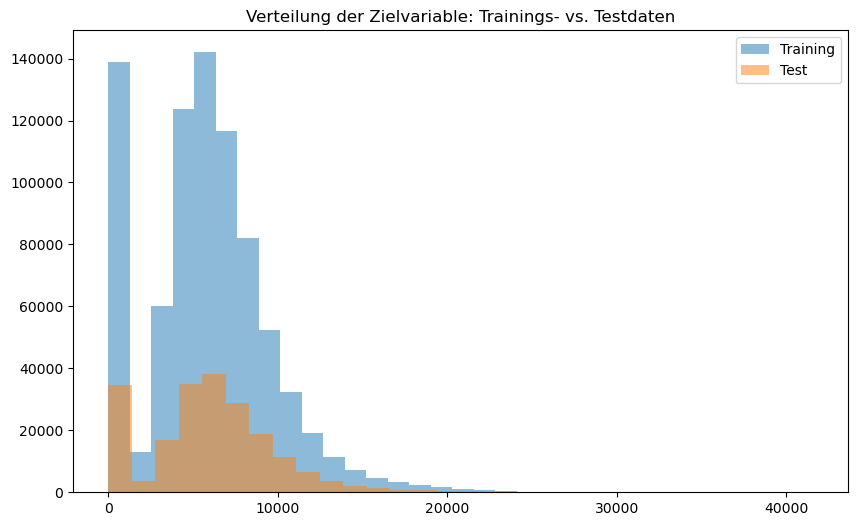

In [365]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.hist(y_train, bins=30, alpha=0.5, label='Training')
plt.hist(y_test, bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title('Verteilung der Zielvariable: Trainings- vs. Testdaten')
plt.show()

## Kaggle Nootebook

In [370]:
import pandas as pd
import numpy as np
import xgboost as xgb

#import missingno as msno
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from time import time
%matplotlib inline

In [362]:
train = pd.read_csv('../data/train.csv',parse_dates=[2])# timeseries
test = pd.read_csv('../data/test.csv',parse_dates=[3])
store = pd.read_csv('../data/store.csv')

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_10409/3354377279.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('../data/train.csv',parse_dates=[2])# timeseries


/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_10409/3811528780.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train.loc[train.Open!=0].Sales)
/opt/anaconda3/envs/rossmann/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


The skewness of Sales is 1.5939220392699809


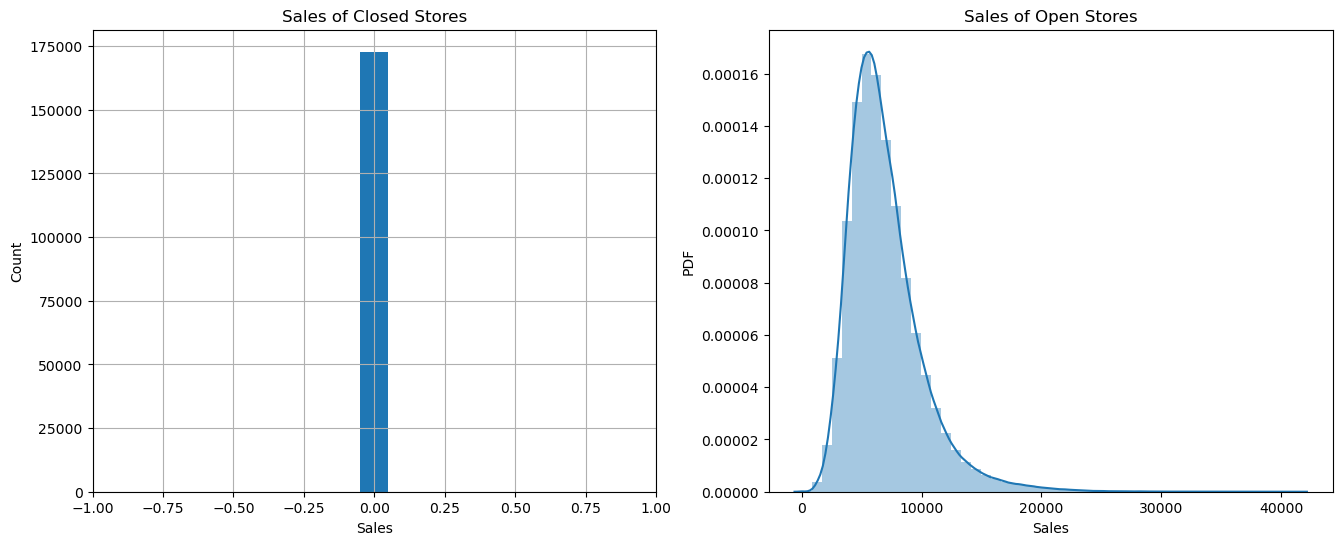

In [364]:
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Count')
ax1.set_title('Sales of Closed Stores')
plt.xlim(-1,1)
train.loc[train.Open==0].Sales.hist(align='left')

ax2 = fig.add_subplot(122)
ax2.set_xlabel('Sales')
ax2.set_ylabel('PDF')
ax2.set_title('Sales of Open Stores')
sns.distplot(train.loc[train.Open!=0].Sales)

print('The skewness of Sales is {}'.format(train.loc[train.Open!=0].Sales.skew()))

In [365]:
train = train.loc[train.Open != 0]
train = train.loc[train.Sales > 0].reset_index(drop=True)

<Axes: title={'center': 'Store1'}, xlabel='Date'>

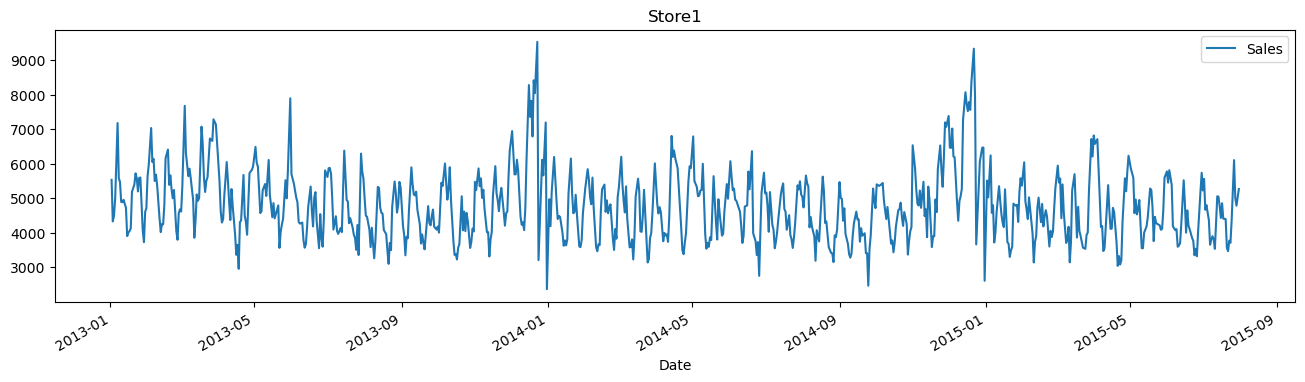

In [366]:
strain=train[train.Sales>0]
strain.loc[strain['Store']==1,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))#,xlim=['2014-6-1','2014-7-31'])

In [367]:
test.fillna(1,inplace=True)

# 对CompetitionDistance中的缺失值采用中位数进行填补
store.CompetitionDistance = store.CompetitionDistance.fillna(store.CompetitionDistance.median())

# 对其它缺失值全部补0
store.fillna(0,inplace=True)

In [368]:
X = store.iloc[:,:].values

In [371]:
si = SimpleImputer(missing_values=np.nan, strategy='most_frequent') #median

#補完
X = si.fit_transform(X)

#新規のDataFrameを生成
store_new = pd.DataFrame(X,columns=list(store.columns))
print(store_new)

     Store StoreType Assortment CompetitionDistance CompetitionOpenSinceMonth  \
0        1         c          a              1270.0                       9.0   
1        2         a          a               570.0                      11.0   
2        3         a          a             14130.0                      12.0   
3        4         c          c               620.0                       9.0   
4        5         a          a             29910.0                       4.0   
...    ...       ...        ...                 ...                       ...   
1110  1111         a          a              1900.0                       6.0   
1111  1112         c          c              1880.0                       4.0   
1112  1113         a          c              9260.0                       0.0   
1113  1114         a          c               870.0                       0.0   
1114  1115         d          c              5350.0                       0.0   

     CompetitionOpenSinceYe

In [372]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [373]:
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [374]:
train=train.sort_values(['Date'],ascending = False)
ho_test=train[:6*7*1115]
ho_train=train[6*7*1115:]

In [375]:
ho_train=ho_train[ho_train['Open']!=0]
ho_train=ho_train[ho_train['Sales']>0]
ho_test=ho_test[ho_test['Open']!=0]
ho_test=ho_test[ho_test['Sales']>0]

In [376]:
# 以下特征处理方式参考：https://blog.csdn.net/aicanghai_smile/article/details/80987666def build_features(features, data):

def features_create(data):
    
      # 字符特征转换为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    data['StoreType'] = data['StoreType'].astype(int)
    data['Assortment'] = data['Assortment'].astype(int)
    data['StateHoliday'] = data['StateHoliday'].astype(int)
    
    
    # 时间特征，使用dt进行处理

    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    # 'CompetitionOpen'：竞争对手的已营业时间
    # 'PromoOpen'：竞争对手的已促销时间
    # 两个特征的单位均为月
    data['CompetitionOpen'] = 12*(data.Year-data.CompetitionOpenSinceYear) + (data.Month-data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12*(data.Year-data.Promo2SinceYear) + (data.WeekOfYear-data.Promo2SinceWeek)/4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    # 'IsPromoMonth'：该天店铺是否处于促销月，1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval==0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
    
    return data

In [377]:
features=[]
# 直接使用的特征
features.extend(['Store','CompetitionDistance','CompetitionOpenSinceMonth','StateHoliday','StoreType','Assortment',
                     'SchoolHoliday','CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear'])
    
features.extend(['Year','Month','Day','DayOfWeek','WeekOfYear'])   
features.extend(['CompetitionOpen','PromoOpen'])
features.append('IsPromoMonth')
len(features)

20

In [378]:
features_create(ho_train)
features_create(ho_test)
features_create(train)
features_create(test)
print('features creation finished')

/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_10409/617593581.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data.StoreType.replace(mappings, inplace=True)
/var/folders/7l/z15ws_pd5x5_76bbfygfn4ch0000gn/T/ipykernel_10409/617593581.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
 

AttributeError: 'DatetimeProperties' object has no attribute 'weekofyear'